In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')



In [2]:
# Создание синтетического датасета с различными проблемами
np.random.seed(42)
n = 1000

# Генерация данных с проблемами
synthetic_data = pd.DataFrame({
    'age': np.round(np.random.normal(35, 10, n)),
    'income': np.random.normal(50000, 15000, n),
    'education': np.random.choice(['HS', 'Bachelor', 'Master', 'PhD', 'Unknown'],
                                n, p=[0.3, 0.4, 0.2, 0.08, 0.02]),
    'city': np.random.choice(['New York', 'Boston', 'Chicago', 'Los Angeles', 'Miami'], n),
    'purchase_amount': np.random.gamma(2, 100, n),  # rate = 1/0.01
    # Добавляем проблемы
    'age_na': np.where(np.random.uniform(size=n) < 0.05,
                      np.nan,
                      np.round(np.random.normal(35, 10, n))),
    'income_outliers': np.where(np.random.uniform(size=n) < 0.03,
                               np.random.normal(150000, 50000, n),
                               np.random.normal(50000, 15000, n)),
    'duplicate_flag': np.random.choice(range(1, 201), n)
})

# Добавляем дубликаты
duplicates = synthetic_data.sample(20, random_state=42)
synthetic_data = pd.concat([synthetic_data, duplicates], ignore_index=True)

print("Размер датасета:", synthetic_data.shape)
print("\nСтруктура данных:")
print(synthetic_data.info())
print("\nПервые 5 строк:")
print(synthetic_data.head())



Размер датасета: (1020, 8)

Структура данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              1020 non-null   float64
 1   income           1020 non-null   float64
 2   education        1020 non-null   object 
 3   city             1020 non-null   object 
 4   purchase_amount  1020 non-null   float64
 5   age_na           972 non-null    float64
 6   income_outliers  1020 non-null   float64
 7   duplicate_flag   1020 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 63.9+ KB
None

Первые 5 строк:
    age        income education         city  purchase_amount  age_na  \
0  40.0  70990.331549  Bachelor      Chicago       152.681435    55.0   
1  34.0  63869.505244        HS  Los Angeles        82.848584    13.0   
2  41.0  50894.455549  Bachelor        Miami       112.295102    35.0   
3  50.0  40

Пропущенные значения по столбцам:
age                 0
income              0
education           0
city                0
purchase_amount     0
age_na             48
income_outliers     0
duplicate_flag      0
dtype: int64


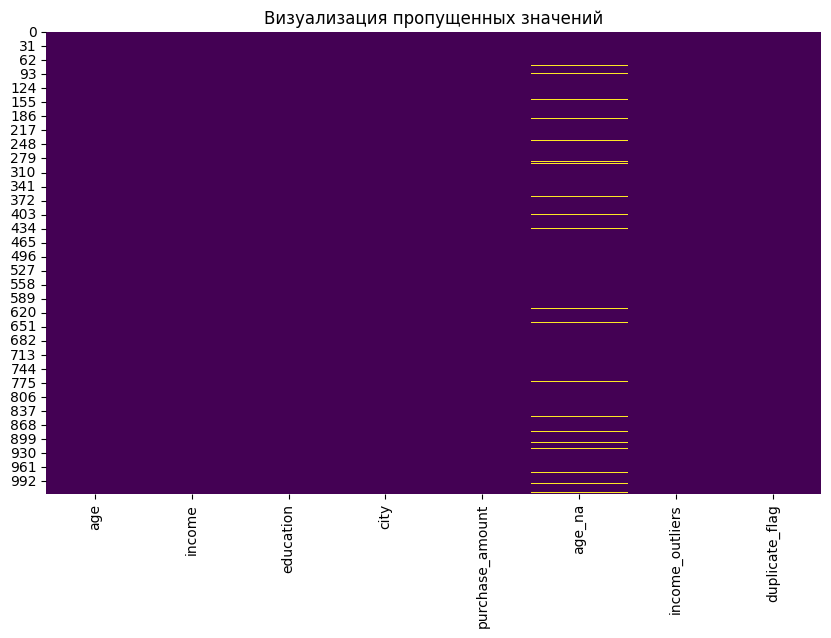

После обработки пропусков: (1002, 8)


In [3]:
# 1. ОБНАРУЖЕНИЕ И ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
def missing_analysis(data):
    print("Пропущенные значения по столбцам:")
    print(data.isnull().sum())

    # Визуализация пропущенных значений
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
    plt.title('Визуализация пропущенных значений')
    plt.show()

missing_analysis(synthetic_data)

# Заполнение пропущенных значений
clean_data = synthetic_data.copy()

# Заполняем age_na медианой
age_na_median = clean_data['age_na'].median()
clean_data['age_na'] = clean_data['age_na'].fillna(age_na_median)

# Заменяем 'Unknown' на NaN и удаляем строки с пропусками в education
clean_data['education'] = clean_data['education'].replace('Unknown', np.nan)
clean_data = clean_data.dropna(subset=['education'])

print("После обработки пропусков:", clean_data.shape)


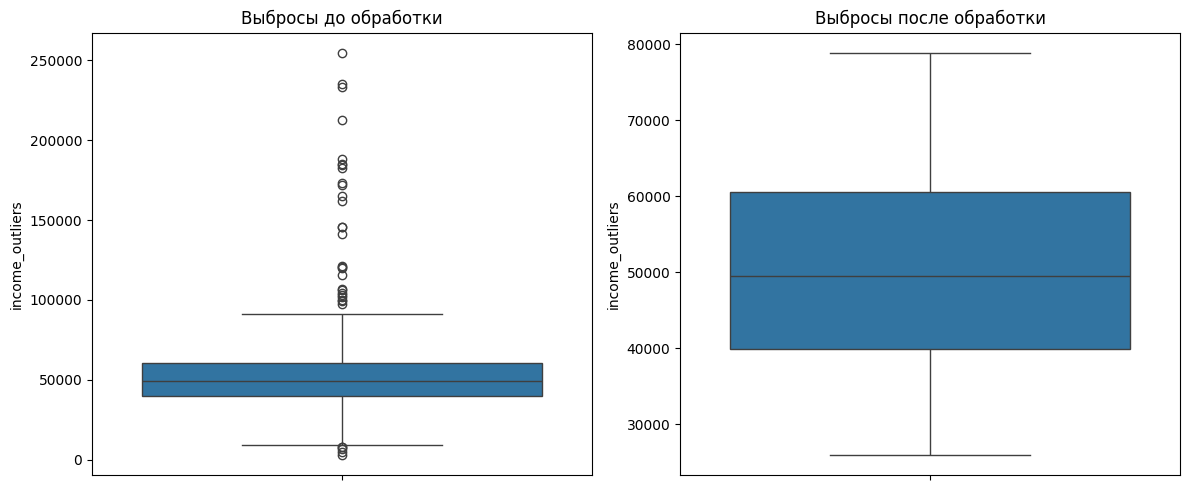

In [4]:

# 2. ОБРАБОТКА ВЫБРОСОВ
def handle_outliers(data):
    # Метод IQR для обнаружения выбросов
    def identify_outliers(x):
        Q1 = x.quantile(0.25)
        Q3 = x.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return (x < lower_bound) | (x > upper_bound)

    # Визуализация выбросов до обработки
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=data['income_outliers'])
    plt.title('Выбросы до обработки')

    # Обработка выбросов - winsorization
    def winsorize(x, limits=(0.05, 0.95)):
        x_quantiles = x.quantile(limits)
        x = x.copy()
        x[x < x_quantiles.iloc[0]] = x_quantiles.iloc[0]
        x[x > x_quantiles.iloc[1]] = x_quantiles.iloc[1]
        return x

    data = data.copy()
    data['income_outliers'] = winsorize(data['income_outliers'])

    plt.subplot(1, 2, 2)
    sns.boxplot(y=data['income_outliers'])
    plt.title('Выбросы после обработки')

    plt.tight_layout()
    plt.show()

    return data

clean_data = handle_outliers(clean_data)



In [5]:
# 3. УДАЛЕНИЕ ДУБЛИКАТОВ
print("Дубликатов до удаления:", clean_data.duplicated().sum())

# Удаляем полные дубликаты
clean_data = clean_data.drop_duplicates()

# Удаляем дубликаты по ключевым полям
clean_data = clean_data.drop_duplicates(subset=['age', 'income', 'education', 'city'], keep='first')

print("Дубликатов после удаления:", clean_data.duplicated().sum())
print("Размер после удаления дубликатов:", clean_data.shape)



Дубликатов до удаления: 18
Дубликатов после удаления: 0
Размер после удаления дубликатов: (984, 8)


In [6]:
# 4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
def encode_categorical(data):
    # One-Hot Encoding для номинальных переменных
    encoder = OneHotEncoder(sparse_output=False, drop='first')

    # Кодируем категориальные переменные
    categorical_cols = ['city', 'education']
    encoded_data = encoder.fit_transform(data[categorical_cols])

    # Создаем DataFrame с закодированными признаками
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=encoder.get_feature_names_out(categorical_cols)
    )

    # Объединяем с исходными данными
    final_data = pd.concat([
        data.drop(categorical_cols, axis=1),
        encoded_df
    ], axis=1)

    print("Размер после кодирования:", final_data.shape)

    return final_data

clean_data_encoded = encode_categorical(clean_data)


Размер после кодирования: (1000, 13)


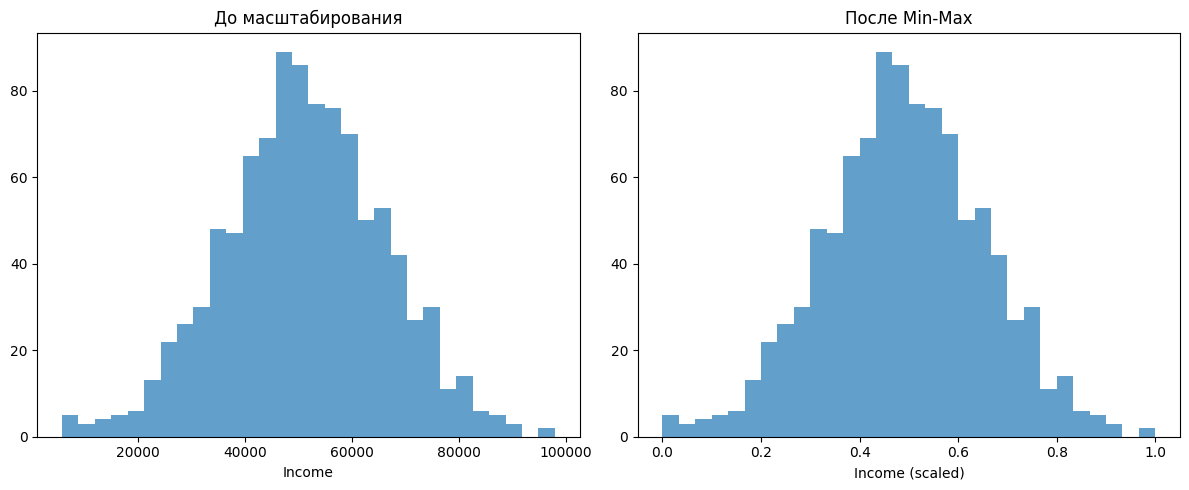

In [7]:

# 5. МАСШТАБИРОВАНИЕ ЧИСЛОВЫХ ПЕРЕМЕННЫХ
def scale_features(data):
    # Min-Max scaling
    min_max_scaler = MinMaxScaler()

    # Z-score standardization
    z_score_scaler = StandardScaler()

    data_scaled = data.copy()

    # Масштабируем признаки
    numeric_cols = ['income', 'purchase_amount', 'age']

    # Min-Max scaling
    data_scaled[['income_scaled', 'purchase_scaled', 'age_scaled']] = min_max_scaler.fit_transform(
        data_scaled[numeric_cols]
    )

    # Z-score scaling (альтернативный вариант)
    # data_scaled[['income_zscore', 'purchase_zscore', 'age_zscore']] = z_score_scaler.fit_transform(
    #     data_scaled[numeric_cols]
    # )

    # Визуализация результатов масштабирования
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.hist(data['income'], bins=30, alpha=0.7)
    ax1.set_title('До масштабирования')
    ax1.set_xlabel('Income')

    ax2.hist(data_scaled['income_scaled'], bins=30, alpha=0.7)
    ax2.set_title('После Min-Max')
    ax2.set_xlabel('Income (scaled)')

    plt.tight_layout()
    plt.show()

    return data_scaled

final_data = scale_features(clean_data_encoded)



In [8]:
# 6. ФИНАЛЬНАЯ ПРОВЕРКА И СОХРАНЕНИЕ
print("\n=== ФИНАЛЬНАЯ ПРОВЕРКА ===")
print("Пропущенные значения:", final_data.isnull().sum().sum())
print("Дубликаты:", final_data.duplicated().sum())
print("Размер финального датасета:", final_data.shape)
print("\nСтруктура данных:")
print(final_data.iloc[:, :8].info())
print("\nПервые 5 строк:")
print(final_data.iloc[:, :8].head())

# Сохранение обработанных данных
final_data.to_csv('preprocessed_data.csv', index=False)
print("\nДанные сохранены в 'preprocessed_data.csv'")

# Дополнительная визуализация результатов
print("\n=== СВОДНАЯ СТАТИСТИКА ===")
print(final_data.describe())


=== ФИНАЛЬНАЯ ПРОВЕРКА ===
Пропущенные значения: 256
Дубликаты: 4
Размер финального датасета: (1000, 16)

Структура данных:
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 954
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               984 non-null    float64
 1   income            984 non-null    float64
 2   purchase_amount   984 non-null    float64
 3   age_na            984 non-null    float64
 4   income_outliers   984 non-null    float64
 5   duplicate_flag    984 non-null    float64
 6   city_Chicago      984 non-null    float64
 7   city_Los Angeles  984 non-null    float64
dtypes: float64(8)
memory usage: 70.3 KB
None

Первые 5 строк:
    age        income  purchase_amount  age_na  income_outliers  \
0  40.0  70990.331549       152.681435    55.0     68977.332507   
1  34.0  63869.505244        82.848584    13.0     43686.485921   
2  41.0  50894.455549       112.295102   